# Fitting with Radial Basis Functions

## Introduction

In a previous assignment, you used linear regression to fit a set of nonlinear basis functions to a set of points in 3D (surface regression). In Project 2, we will explore a special nonlinear basis called the **radial basis functions** and see how these functions can be used to better fit a surface to a set of ponts. If you have heard of Machine Learning, a popular form of AI, then you'll be happy to know that radial basis functions are very common in Supervised Machine Learning!

*Note:* As you walk through the notebook, if there is a cell that contains code or a step that you don't quite understand, feel free to create a new block right below the cell and type $\texttt{@show}$ $\texttt{variable_name}$ to display the contents of the variable. This can help to expose some of the intermediate steps.

In [62]:
using Plots, LaTeXStrings, LinearAlgebra, Random
gr()
default(
    titlefont = (16, "times"), 
    legendfontsize = 12, 
    guidefont = (14), # Changes x and y axis label fonts
    linewidth = 2)

In [63]:
import Pkg; Pkg.add("LaTeXStrings")

   Resolving package versions...
  No Changes to `C:\Users\qpow3\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\qpow3\.julia\environments\v1.7\Manifest.toml`


To build up intuition for some of the properties of the radial basis function, let's first explore trying to fit a curve to "noisy" measurements corresponding to a real-valued function. We will generate realistic measurements by selecting points on the x axis and adding "noise" (that is, random numbers) to the corresponding output value of the function. If this is abstract, you can think of the y values of the function as temperature values, the x values as the measurement time and the noise as the measurement error that is inherent to our specific sensor.

Create a new cell block and type ``?randn`` to find out more about the noise being added. 

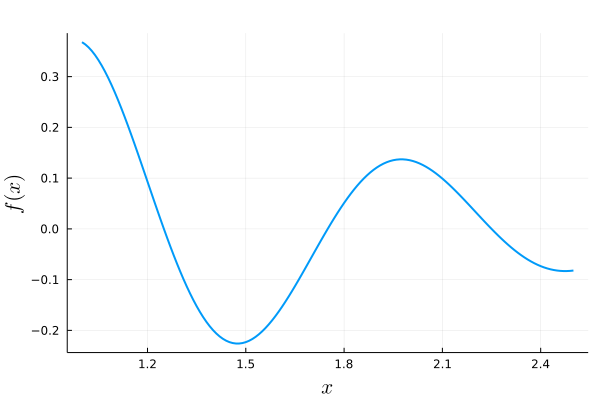

'latex' is not recognized as an internal or external command,
operable program or batch file.
'latex' is not recognized as an internal or external command,
operable program or batch file.
'latex' is not recognized as an internal or external command,
operable program or batch file.
'latex' is not recognized as an internal or external command,
operable program or batch file.
latex: failed to create a dvi file
latex: failed to create a dvi file
latex: failed to create a dvi file
latex: failed to create a dvi file


In [64]:
# Run me, don't change me. I will generate a plot for you. 
#
# Create a known function with no noise

x_actual = collect(1:0.01:2.5);
y_actual = cos.(2π * x_actual) .* exp.(-x_actual);
plot(x_actual, y_actual, title=L"$f(x) = e^{-x}cos(2\pi x)$", legend=false)
xlabel!(L"x")
ylabel!(L"f(x)")

In [65]:
?randn

search: randn randn! randstring lowrankdowndate lowrankdowndate!



```
randn([rng=GLOBAL_RNG], [T=Float64], [dims...])
```

Generate a normally-distributed random number of type `T` with mean 0 and standard deviation 1. Optionally generate an array of normally-distributed random numbers. The `Base` module currently provides an implementation for the types [`Float16`](@ref), [`Float32`](@ref), and [`Float64`](@ref) (the default), and their [`Complex`](@ref) counterparts. When the type argument is complex, the values are drawn from the circularly symmetric complex normal distribution of variance 1 (corresponding to real and imaginary part having independent normal distribution with mean zero and variance `1/2`).

# Examples

```jldoctest
julia> using Random

julia> rng = MersenneTwister(1234);

julia> randn(rng, ComplexF64)
0.6133070881429037 - 0.6376291670853887im

julia> randn(rng, ComplexF32, (2, 3))
2×3 Matrix{ComplexF32}:
 -0.349649-0.638457im  0.376756-0.192146im  -0.396334-0.0136413im
  0.611224+1.56403im   0.355204-0.365563im  0.0905552+1.31012im
```


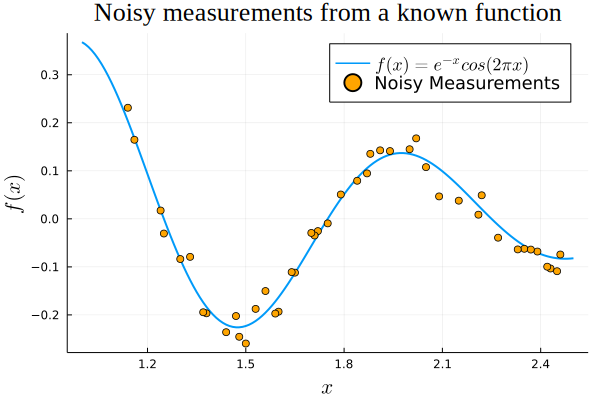

In [66]:
# Run me, don't change me. I will generate the following for you:
#     - x_measured a vector of real numbers of points where the function is "measured"
#     - y_measured a vector of real numbers of points corresponding to "noisy" measurements
#     - A plot with our function + the points we sampled from it with noise

# Randomly sample N points along the x axis
N = 50

# Allows us to get the same random numbers every time we run this cell
Random.seed!(12345678)

# We use unique because after flooring the numbers (rounding numbers to the nearest 
# integer less than or equal to the number), we may have repeated indices
idx = Int.(unique(floor.(rand(N) * length(x_actual))) .+ 1) # random indices
N   = length(idx);

x_measured = x_actual[idx]; # Training input

# Noise from a scaled normal distribution
y_measured = y_actual[idx] + 0.02 * randn(N)

plot(x_actual, y_actual, title="Noisy measurements from a known function",
    label=L"$f(x) = e^{-x}cos(2\pi x)$", xlabel=L"$x$", ylabel=L"$f(x)$")
scatter!(
    x_measured, 
    y_measured, 
    c=:orange, # set the color
    label="Noisy Measurements", 
    legend=:best) # automatically use best location to place legend in graph

Now imagine that we were given the indicated noisy measurements and we would like to fit a function to them. Here, we know what the function is, but in practice, all we know are the measured values! How can we go about finding a function that explains the data?

Let's start with trying to use a basis often used in the textbook, namely monomials (powers of x). Remember that the basis functions can themselves be nonlinear. It is only the way that we combine the functions together that needs to be linear (a linear combination). We refer to our suggested pipeline for fitting the measurements to the basis functions (in the booklet Least Squares via the QR factorization). The 'A' term in regression is sometimes called the phi ($\Phi$) matrix or design matrix.

[![QR-Axb-pipeline.png](https://i.postimg.cc/dtHdnyrV/QR-Axb-pipeline.png)](https://postimg.cc/kBSBgDT0)

To efficiently solve for x in the pipeline, we can take advantage of R being an upper-triangular matrix and use back substitution. We bring the backwardsub function from HW4 below.

In [67]:
# Run me, don't change me. I will create a back substitution function that you can apply
# to systems of linear equations with an upper triangular "A" matrix, that we denote by U

"""
backwardsub(U, b)

It solves for x in an equation Ux = b, where U is upper triangular.
"""
function backwardsub(U, b)
    
    # Assert no entries in the diagonal of U
    # are 0 (or very close to 0)
    @assert minimum(abs.(diag(U))) > 1e-6
    
    n = length(b)
    x = Vector{Float64}(undef, n)

    x[n] = b[n] / U[n,n]
    for i in n-1:-1:1
        x[i]=(b[i] - (U[i,(i+1):n])' * x[(i+1):n]) ./ U[i,i]
    end
    
    return x    
end

backwardsub

Our goal is to find a set of coefficients $a_1$, $a_2$, $a_3$, $a_4$ such that for every measured point $x_i$, our model produces a prediction or output as close to the actual $y_i$ value as possible. The error between our model prediction and our actual value is $e_i = y_i - \hat{y}_i$.

$$\hat{y} = a_1 + a_2 x + a_3 x^2 + a_4 x^3 $$

We refer to our coefficients collectively as $a_{star} = [a_1, a_2, a_3, a_4]$. As we will see in the next couple of cells, the use of monomials as basis functions will not be a great design choice here. However, we use it for the purpose of illustrating the value of radial basis functions. 

## Task 1: Construct a Phi Matrix

With the model described above, we can form a set of linear equations where each equation is formed by evaluating the $x_i$ value of our measurement to obtain a predicted $\hat{y}_i$ value.

\begin{equation*}
\hat{y}_1 = a_1 + a_2x_1 + a_3x_1^2 + a_4x_1^3 \\
\hat{y}_2 = a_1 + a_2x_2 + a_3x_2^2 + a_4x_2^3 \\
\vdots
\end{equation*}

With our linear equations written out, we can now write the set of linear equations succinctly as $\hat{Y} = \Phi a_{star}$. For Task 1, write in the code necessary to construct $\Phi$ given our model. __Hint:__. Since our model has 4 coefficients, the size of $\Phi$ will be N x 4 where N is the number of measurements we have taken.

In [68]:
# Fill in code to define the phi matrix.
#
# basis = [1, x, x^2, x^3]
#phi = [x_measured ones(44,4)]
phi = [ones(length(x_measured)) x_measured x_measured.^2 x_measured.^3]

# This is how you do QR Factorization of the matrix ``phi`` in Julia
F = qr(phi)
Q=Matrix(F.Q)
R=Matrix(F.R)

# Display Q and R to verify sizes and types
@show size(phi);
@show size(Q);
@show size(R);
@show typeof(Q);
@show typeof(R);

size(phi) = (44, 4)
size(Q) = (44, 4)
size(R) = (4, 4)
typeof(Q) = Matrix{Float64}
typeof(R) = Matrix{Float64}


In [69]:
# Autograder cell
### BEGIN HIDDEN TESTS
p1_task1_phi = [ones(length(x_measured)) x_measured x_measured.^2 x_measured.^3];
@assert isapprox(phi, p1_task1_phi)
### END HIDDEN TESTS

In previous homeworks you used the Gram-Schmidt Process to construct the Q matrix. In this project we will use the $\texttt{qr}$ function from the linear algebra package which produces the same Q and R matrices that can be obtained via Gram-Schmidt. Using the implementation in the qr package results in more numerically stable results (algorithms that naively divide frequently produce really small numbers which are hard for computers to represent accurately). To properly index into Q and R make sure to pass each component in the output to the $\texttt{Matrix}$ function.

## Least Squares QR Pipeline

In [70]:
# We continue our illustration of regression, where the least squared error fit
# is determined via the QR Factorization. Run the cell, don't change anything. 
# Pay attention, though!
#
# Pipeline for Least Squares using QR factorization
b_bar = Q' * y_measured
a_star = backwardsub(R, b_bar)

# Save the coefficients to be used for later
a_monomial = copy(a_star)

# Julia can represent characters in something known as unicode which
# allows for typesetting using more than the keys on your keyboard.
# To create the variable a₁ type a\_1 and then hit tab
# right after and julia will reformat your varaible name.
@show a₁ = a_star[1];
@show a₂ = a_star[2];
@show a₃ = a_star[3];
@show a₄ = a_star[4];

a₁ = a_star[1] = 11.914460345434891
a₂ = a_star[2] = -21.293855824010294
a₃ = a_star[3] = 12.222600208783108
a₄ = a_star[4] = -2.263907292819421


In [71]:
@assert 1 < 2, 

LoadError: syntax: incomplete: premature end of input

Finally, now that we have our weights for the basis, let's see how good our fit is by obtaining estimates of the function with our model at all points along the x axis used to plot the original function. A way to quantify how well our model fits is to calculate the total fitting error. We will calculate our error by comparing how well our model predicts the values we actually measured (remember, we wouldn't know the actual function in practice. We define the fitting error $E_{tot}$ below where $y_i$ is the true value obtained from our known function at $x_i$, and $\hat{y}_i$ is the ouput of our model after evaluating it with $x_i$.

$$E_{tot} = \sum_{i=1}^{N}(e_i)^2 = e^\intercal e = (\hat{y}_i - y_i)^\intercal(\hat{y}_i - y_i) = ||\hat{y}_i - y_i||^2_2$$


The next cell provides us a small helper function to calculate this error.

In [72]:
# Run me, don't change me! I create a function that
# helps to calculate the fitting error of our
# monomial model

"""
error_monomial_fit(a, X)

Calculates and returns the error E_tot defined as:

            E_tot = Σ(yhat_i - y_i)^2

between the monomial model and the actual function
"""
function error_monomial_fit(a, X)
    
    @assert size(a,1) == 4
    
    # Calculate the value of the model: y_hat = a₁ + a₂x + a₃x^2 + a₄x^3
    y_hat = a[1]*ones(length(X)) + a[2]*X + a[3]*X.^2 + a[4]*X.^3

    # Return the error E_tot
    return (y_measured - y_hat)' * (y_measured - y_hat)
end

error_monomial_fit

Monomial Fitting Error: 0.16917367148524665


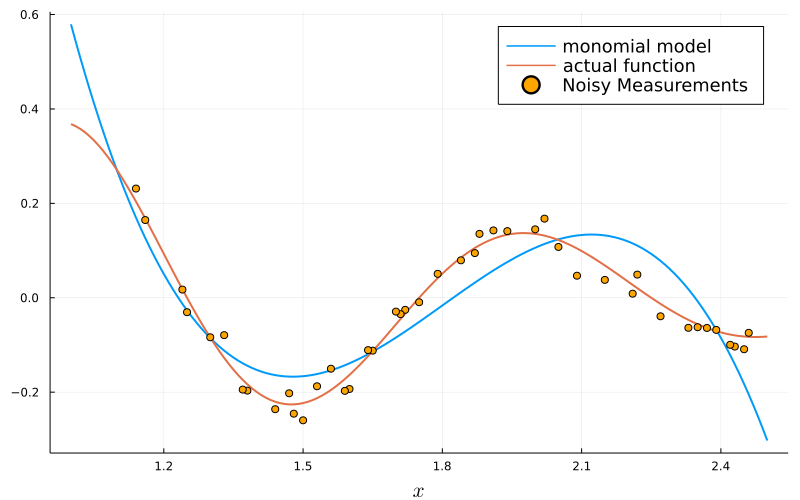

In [73]:
# Run me, don't change me! We illustrate here how to generate 
# a plot of the estimated function and report the fitting error.
# We use the same x points we used for drawing our original 
# function to draw our regressed function

y_hat = a₁*ones(length(x_actual)) + a₂*x_actual + a₃*x_actual.^2 + a₄*x_actual.^3

# Calculate and display the fitting error
etot = error_monomial_fit(a_star, x_measured)
println("Monomial Fitting Error: ", etot)

plot(x_actual, y_hat, label="monomial model", xlabel=L"$x$")
plot!(x_actual, y_actual, label="actual function")
scatter!(x_measured, y_measured, c=:orange, label="Noisy Measurements", 
    legend=:best, size=(800,500))

While the general shape seems to be identified, the crests in the plot do not match well and we can see that, if we were to extend the x axis in either direction, the two curves would diverge significantly. Let's plot the basis functions individually and get a feel for the individual functions we are adding up. As you move through the notebook, the goal will be to arrive at a model that will produce a lower fitting error than the one above.

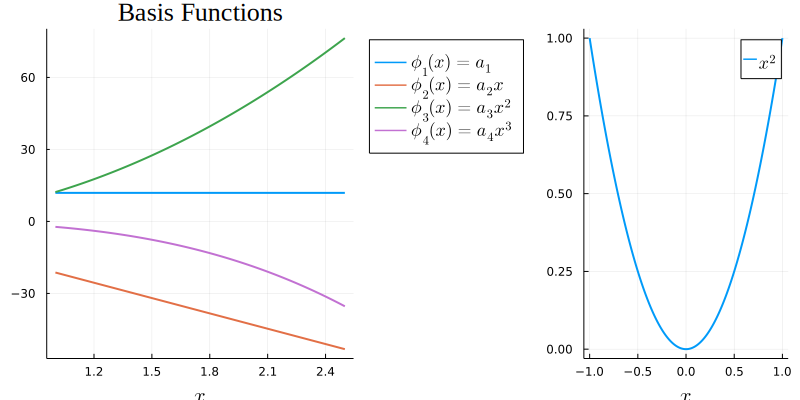

In [74]:
#Run me, don't change me !
#
# I create two plots. The first plot shows a line for each of the 4 monomials 
# in our model. The second plot shows a picture of x^2 to use as a reference.

l = @layout [a{0.7w} b{0.3w}]
p1 = plot(x_actual, a₁*ones(length(x_actual)), label=L"$\phi_1(x) = a_1$")
plot!(p1, x_actual, a₂*x_actual, label=L"$\phi_2(x) = a_2 x$")
plot!(p1, x_actual, a₃*x_actual.^2, label=L"$\phi_3(x) = a_3 x^2$")
plot!(p1, x_actual, a₄*x_actual.^3, label=L"$\phi_4(x) = a_4 x^3$",
    legend=:outertopright)
xlabel!(L"$x$")
title!("Basis Functions")

x_sq = collect(-1:0.01:1)
p2 = plot(x_sq, x_sq.^2, label=L"x^2")
xlabel!(L"$x$")
plot(p1, p2, layout=l, size=(800,400))

What are some things you might notice about each of the individual monimals you've plotted? If someone asked you to describe the shape of the $x^2$ you might say that it's bowl shaped. However, in the image above, we see only a portion of a _really_ big bowl. One of the issues of using the monomial basis functions is that if we take $x^2$ for example, regression tries to fit it to all the measurements. What if we could have it just fit ONLY the measurements near the bowl shape at $x$=1.5 in the orignal (actual) function. Said another way, what if we could _locally_ fit the basis functions to certain parts of the data?

## The Radial Basis Function

$$f(x; x_c, s) = exp(\frac{-\|x-x_c\|^2}{2s^2})$$

The equation above is the formula for a generic Radial Basis Function (RBF). $x$ and $x_c$  are vectors in $\mathbb{R}^n$. Both $x_c$ and s are known before evaluating the function and are said to parameterize the function. Just as $y=2x$ and y=$-3x$ are both equations for lines but the value of the slope changes the steepness of the line, we will find that our radial basis function always has a bell-shaped curve that changes it's look based on the values of $x_c$ and $s$.

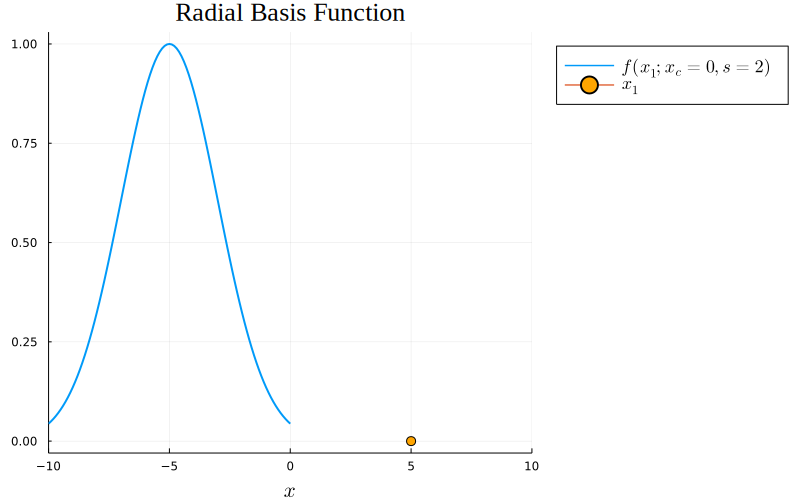

In [75]:
# For this cell, try out different values for each of the
# three variables listed below with the suggested range for 
# each variable in the comments. The cell will display the 
# RBF function.

## EDIT ##
x1 = 5  # Try values between [-5, 5]
xc = -5  # Try values between [-5, 5]
s = 2   # Try values between [0.1, 2]
## EDIT

# The radial basis function
rbf(x1, xc, s) = exp.(-norm(x1-xc)^2 / (2*s^2))

x = collect(-5:0.1:5) .+ xc
y = [rbf(val, xc, s) for val in x]
    
plot(x, y, xlabel=L"$x$", label="\$f(x_1;x_c=0,s=$s)\$",
    title="Radial Basis Function", xlims=(-10,10))
plot!([x1], [rbf(x1, xc, s)], marker=:orange, markersize=5, 
    label=L"$x_1$", legend=:outertopright, size=(800,500))

Take a few minutes to understand what how changing each input to the function affects the plot. As you play around with the inputs you should notice the following:

* $x_1$: as $x_1$ get's further and further in either direction away from $x_c$, the value of the function becomes smaller. It is the largest when $x_1$ is exactly $x_c$. This makes sense because of we look at the numerator in the exponent of our RBF, $\|x_1-x_c\|^2$ just represents the norm (distance) between two vectors. However, because we are negating the power in the function ($\exp(-...)$), large norms lead to small ouptut values.

* $x_c$: changes where the peak of the bell curve lies. We can think of this as the function's center.

* $s$: changes how narrow or wide our function is


## Task 2: Fitting By Hand with Radial Basis Functions

In the last set of cells, we looked at how the inputs of the RBF change the shape of the function. In this task, we explore trying to fit our original real-valued function $f(x) = e^{-x}cos(2\pi x)$ with two RBFs. We can write our model as follows (ignoring the constant term for now):

$$\hat{y} = a_1 f(x; x_{c_1}, s) + a_2 f(x; x_{c_2}, s)$$

Note that in this formulation, the width parameter $s$ is shared between both RBFs. Typically when using RBF's there will be one width parameter shared among all of the basis functions. For the rest of this project, we will do so as well. In the next two cells, we provide two helper functions to plot our model and calculate the fitting error with our two RBF model.


In [76]:
# Run me, don't change me. I will create a function
# that will plot our 2 RBF model along with our
# original function using the parameters provided

"""
plot_2rbf_model(a₁, xc1, a₂, xc2, s)

Plots the 2 RBF model along with the original function.
The model is defined as: 

       y_hat = a₁f(x; xc1, s) + a₂f(x; xc2, s)
"""
function plot_2rbf_model(a₁, xc1, a₂, xc2, s)
    
    # Calculate the value of the model: y_hat = a₁f(x; xc1, s) + a₂f(x; xc2, s)
    # at each data point val in x_actual and arrange it as a vector
    y_rbf = [a₁ * rbf(val, xc1, s) + a₂ * rbf(val, xc2, s) for val in x_actual]
    
    plot(x_actual, y_actual, title="Partial Data Fit", line=:dash,
        label=L"$f(x) = e^{-x}cos(2\pi x)$", xlabel=L"$x$", ylabel=L"$f(x)$")
    plot!(x_actual, y_rbf, label="\$$a₁ f(x_1;x_c=$xc1,s=$s) + $a₂ f(x;x_c=$xc2,s=$s)\$")
    scatter!(x_measured, y_measured, c=:orange, label="Noisy Measurements", 
        legend=:best, size=(800,500)) 
end

plot_2rbf_model

In [77]:
# Run me, don't change me. I will create a function
# that will calculate the total error between our
# model predicted values and the actual measurements

"""
error_2rbf_fit(a₁, xc1, a₂, xc2, s, x)

Calculates and returns the error E_tot defined as:

            E_tot = Σ(yhat_i - y_i)^2
"""
function error_2rbf_fit(a₁, xc1, a₂, xc2, s, x)
    
    # Calculate the value of the model: y_hat = a₁f(x; xc1, s) + a₂f(x; xc2, s)
    # at each data point val in x and arrange it as a vector
    y_hat = [a₁ * rbf(val, xc1, s) + a₂ * rbf(val, xc2, s) for val in x]
    
    return (y_measured - y_hat)' * (y_measured - y_hat)
end

error_2rbf_fit

For this task, you will tune by hand 5 parameters to minimize the fitting error $E_{tot}$ of our model. The parameters $a_1$ and $a_2$ are the coefficients of our model, $xc1$ and $xc2$ are the centers of our RBFs and $s$ is the shared with parameter. Because we are only using two RBFs and are tuning the parameters by hand, the goal is to identify a parameter set the produces a total error that is less that 0.5.

To start off, it is suggested to fit one RBF at a time. Set the coefficient $a_2$ to 0 if it is not 0 by default and adjust the parameters $a_1$, $xc1$, $s$ to approximately fit one of the two humps in the function. Once that's done, begin to modify $a_2$ and $xc2$. As you start fitting the second RBF, you may want to revisit some of your values for $s$, $a_1$, and $xc2$.

Monomial Fitting Error: 0.16917367148524665
2 RBF Fitting Error   : 0.4888805628591825


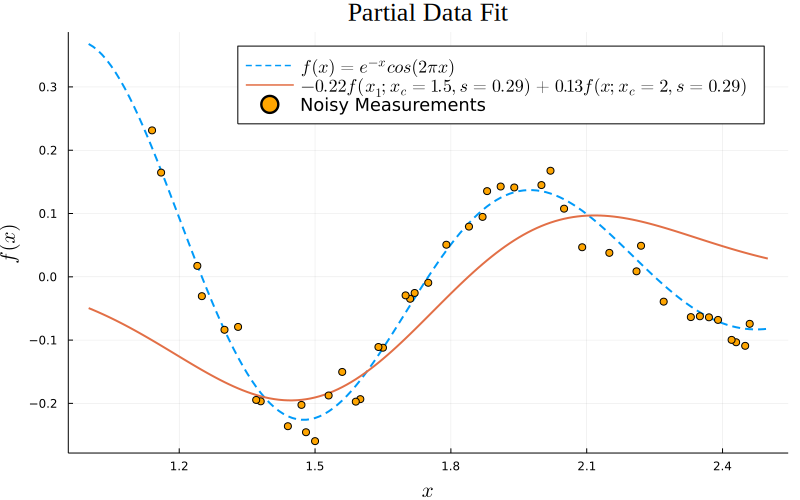

In [78]:
# Modify this cell. In this cell you will tune the values in
# the edit section to fit two RBFs to our original function
# Each time you run this cell will plot the model defined
# by the parameters as well as display the fitting error

######     EDIT     ######
a₁  = -0.22  # Try values in between [-1, 1] 
xc1 = 1.5  # Try values in between [1, 2.5]
s   = 0.29  # Try values in between [0, 0.3]
xc2 = 2  # Try values in between [1, 2.5]
a₂  = 0.13   # Try values in between [-1, 1]
######     EDIT     ######

# Display error
etot_2rbf = error_2rbf_fit(a₁, xc1, a₂, xc2, s, x_measured)
etot_monomials = error_monomial_fit(a_monomial, x_measured)
println("Monomial Fitting Error: ", etot_monomials)
println("2 RBF Fitting Error   : ", etot_2rbf)

# Plot model
plot_2rbf_model(a₁, xc1, a₂, xc2, s)

In [79]:
# Autograder cell
### BEGIN HIDDEN TESTS
p2_task2_etot_2rbf = error_2rbf_fit(a₁, xc1, a₂, xc2, s, x_measured)
@assert p2_task2_etot_2rbf < 0.5
### END HIDDEN TESTS

Congratulations! You have just fit using RBFs and we hope you can see that with just two bases that we are already getting a significantly better fit in the middle portion of the x-axis. At the moment, with just two basis, the total fitting error is still many times larger due to the deviation at the tails, but as we add more basis we can begin to get a closer fit at the ends of the function as well. A lot of the magic of the fit comes from the fact that values evaluated far away from the center of a RBF are very close to 0. This makes it very nice to use in our linear model. However, you still may have needed to have gone back and adjusted the parameters of the first RBF once you started adjusting the parameters of the second. Now that we have an understanding of the benefits of using RBFs for fitting, let's see if we can use our least squares pipeline to find a model and a set of coefficients that has a lower fitting error than our monomial model.

## Fitting using Least Squares and RBFs

To start using more RBFs in our model, let's first expand our model and also add back the constant term. M represents the number of RBFs we decide to use in our model.

$$\hat{y} = a_1 + a_2 f(x; x_{c_1}, s) + a_3 f(x; x_{c_2}, s) + ... + a_{M+1} f(x; x_{c_M}, s)$$

Looking back up top to the least squares QR factorization excerpt from the book, to use the pipeline, the first step we need to do is construct the regressor matrix ($\Phi$). When using the monomials, $\Phi$ looked like so:

$$
\begin{equation} \label{eq:monomial_mat_form}
    \underbrace{
    \begin{bmatrix}
    \hat{y}_1 \\
    \hat{y}_2 \\
    \vdots \\
    \hat{y}_N
    \end{bmatrix}}_{\hat{Y}}
    =
    \underbrace{
    \begin{bmatrix}
    1 & x_1 & x_1^2 & x_1^3 \\
    1 & x_2 & x_2^2 & x_2^3 \\
    \vdots & \vdots & \vdots & \vdots \\
    1 & x_N & x_N^2 & x_N^3
    \end{bmatrix}}_{\Phi}
    \underbrace{
    \begin{bmatrix}
    a_1 \\
    a_2 \\
    a_3 \\
    a_4
    \end{bmatrix}}_{\alpha}
\end{equation}
$$

With our RBFs, a single row in our $\Phi$ matrix can now be determined by following the below construction of a row where $x_i$ is the ith measurement out of N total measurements, $s$ is the shared RBF width parameter (also sometimes refered to by the name kernel width) and $x_{c_1}$ through $x_{c_m}$ are M different basis centers. The next few cells provide some useful helper functions that we will use in our pipeline.

$$
\begin{bmatrix}
    1 & f(x_i;x_{c_1},s) & f(x_i;x_{c_2},s) & ... & f(x_i;x_{c_M},s) \\
\end{bmatrix}
$$

In [80]:
# Run me, don't change me. I will create a function
# will be helpful in assembling our Φ matrix assuming
# our model is a linear combination of RBFs

"""
function calc_phi_row(x, centers, s)

Returns a single row in the Φ matrix

Inputs:
    xᵢ      - the measurment xᵢ
    centers - a Mx1 vector holding the centers of the determined RBFs
    s       - the shared kernel width (RBF width)
"""
function calc_phi_row(xᵢ, centers, s)
   
    phi_row_size = length(centers) + 1
    phi_row = Array{Float64, 1}(undef, phi_row_size)
    phi_row[1] = 1
    
    for i in 2:phi_row_size
        phi_row[i] = rbf(xᵢ, centers[i-1], s)
    end
    
    return phi_row
end

calc_phi_row

In [81]:
# Run me, don't change me. I will create a function
# that returns the regressor matrix Φ based on our
# model using RBFs as basis functions

"""
function regressor_matrix()

Returns the regressor matrix Φ

Inputs:
    X       - a Nx1 vector holding the X value of all the measurements
    centers - a Mx1 vector holding the centers of the determined RBFs
    s       - the shared kernel width (RBF width)
"""
function regressor_matrix(X, centers, s)
    
    N = length(X)
    M = length(centers)
    phi = Array{Float64, 2}(undef, N, M+1)
    
    for i in 1:N
        phi[i, :] = calc_phi_row(X[i], centers, s)'
    end
    
    return phi
end

regressor_matrix

In [57]:
# Run me, don't change me. 

"""
function least_squares_qr(A::Array{Float64,2},  b::Array{Float64,1})

Solves for x in Ax = b using the QR factorization. Returns x.
"""
function least_squares_qr(A::Array{Float64,2},  b::Array{Float64,1})
    F = qr(A)
    Q = Matrix(F.Q)
    R = Matrix(F.R)
    b_bar = Q' * b
    return backwardsub(R, b_bar)    
end

least_squares_qr

## Task 3: Identify the Fitting Parameters

Now that we have some helper functions, let's see how well we can fit our samples using radial basis functions and the least squares pipeline to calculate the optimal coefficients for our model. The goal of this task is to produce a fitting error that is less than the error we have with our monomial model. In this task, you will play around with the two parameters, $s$ and $M$, which you can set in the next cell. $s$ represents the width each RBF will use. $M$ represents the number of radial basis functions in our model. 

In the next cell, we use $M$ to select our basis centers and display them in a plot. The centers should be selected in the domain (x range) of the data, so we randomly select some of the measured x values to use as our centers. As we saw when we just used 2 RBFs, we need to place enough RBFs to sufficiently cover the domain of the data (so our model fits the tails of the function just as well as the middle of it). One way to achieve this is to randomly select values from the data to use as basis centers. Because $\texttt{x_measured}$ is not sorted, when we select indices below, the centers will seem to appear at random.

Centers at x = [2.43, 1.47, 1.6, 1.56]


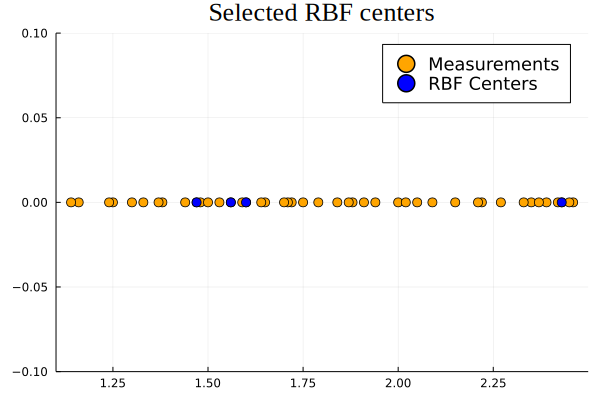

In [82]:
# Modify this cell by changing the number of basis
# functions (M) to use in our model and the width s.

## Edit ##
M = 4
s = 0.29
## Edit ##

# If we have N measurements, select M of them evenly spaced by index from 1 to N
# Note that because the measurements are not sorted as you change M, they
# will appear to be selected at random from x_measured
center_indices = Int.(floor.(collect(range(1, N, length=M))))

# Creating a vector like this is known as using list comprehension
# Read it as - for every element i in center_indices get the ith value in x_measured
centers = [x_measured[i] for i in center_indices]
println("Centers at x = ", centers)

# Visually see selected RBF centers
scatter(x_measured, zeros(N,1), markersize=5, c=:orange, label="Measurements", title="Selected RBF centers")
scatter!(centers, zeros(M,1), markersize=5, c=:blue, label="RBF Centers", legend=:best)
ylims!((-0.1,0.1))

*Note*: Some combinations of $M$ and $s$ result in a $U$ matrix in the backwardsub function whose columns are not linearly independent. In this case, you will be met with an assertion error that checks if any of the diagonal elements are close to 0: $\texttt{minimum(abs.(diag(U))) > 1.0e-6}$. This happens when some basis centers are really close and the $s$ value is large. Consider using a smaller $s$ value or changing the value of $M$ to obtain a different set of centers.

In [85]:
# Run me, don't change me! I implement the 
# least squares pipeline

# Calculate the coefficients in the model
phi = regressor_matrix(x_measured, centers, s)

a_star = least_squares_qr(phi, y_measured)

# Using the model, estimate the value at every x value we used to
# to plot the original function. We can reuse our calc_phi_row
# function to quickly evaluate the x value at each RBF and 
# evaluate the linear combination using vector multiplication
for i in 1:length(x_actual)
   y_hat[i] = a_star' * calc_phi_row(x_actual[i], centers, s)
end

In [84]:
# Run me, don't change me! I implement a helper
# function the computes the fitting error using
# the multiple RBF model 

"""
error_rbf_fit(a_star, centers, s, X)

Calculates and returns the error E_tot defined as:

            E_tot = Σ(yhat_i - y_i)^2

between the rbf model and the actual function

Inputs:
    a_star  - a M+1 element vector with the coefficients for our model
    centers - a Mx1 vector indicating where the center of each RBF along
              the x axis is located
    s       - the shared width parameter for all RBFs
    X       - a Nx1 vector of data points that shall be predicted with
              our model
"""
function error_rbf_fit(a_star, centers, s, X)
    
    y_hat = Array{Float64, 1}(undef, length(X))
    for i in 1:length(X)
        y_hat[i] = a_star' * calc_phi_row(X[i], centers, s)
    end

    # Return the error E_tot
    return (y_measured - y_hat)' * (y_measured - y_hat)
end

error_rbf_fit

Monomial Fitting Error: 0.16917367148524665
RBF Fitting Error     : 0.03135546068239384


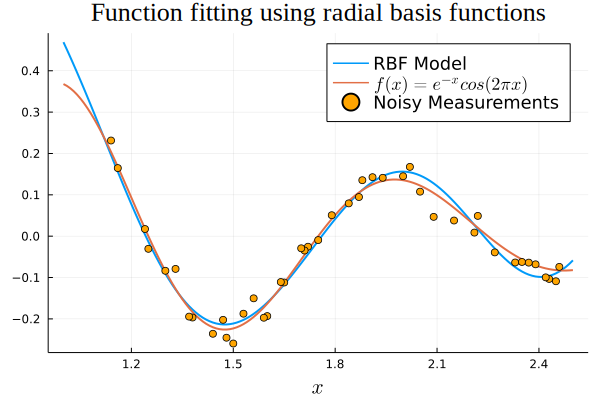

In [86]:
# Run me, don't change me! I compare the monomial
# fitting error with the error of our new RBF model
# and additionally display the fit

# Calculate and display the fitting error
etot_monomial = error_monomial_fit(a_monomial, x_measured)
etot_rbf = error_rbf_fit(a_star, centers, s, x_measured)
println("Monomial Fitting Error: ", etot_monomial)
println("RBF Fitting Error     : ", etot_rbf)

# Plot the results
plot(x_actual, y_hat, label="RBF Model")
plot!(x_actual, y_actual, label=L"$f(x) = e^{-x}cos(2\pi x)$", xlabel=L"$x$",)
scatter!(x_measured, y_measured, c=:orange, label="Noisy Measurements", legend=:best)
title!("Function fitting using radial basis functions")

In [87]:
# Autograder cell
### BEGIN HIDDEN TESTS
task3_etot_rbf = error_rbf_fit(a_star, centers, s, x_measured)
@assert task3_etot_rbf < etot_monomial
### END HIDDEN TESTS

## Reflection

We have seen in this notebook that we can use radial basis functions to create a smooth fit. In project 2, instead of taking data and fitting a line (1D), we attempt to take 2D data and fit a surface to it. Spend some time thinking about what the parameters of the radial basis function, specifically what $x_c$  and $s$ represent, when the problem is extended into 2D.